
# LangGraph Reflection 机制开发指南

本指南详细介绍了如何在 **LangGraph** 中构建基于大语言模型（LLM）的 **Reflection（反思）** 机制。

Reflection 是一种重要的模型能力，通过让模型观察其过去的步骤和外部环境反馈，评估自身行为的质量，并不断改进输出。在生成与反思的循环中，模型可以逐步优化内容，从而提升生成质量和用户满意度。

Reflection 机制被广泛应用于生成任务中，例如文章写作、内容修改与反馈、以及智能助理等场景。通过引导 LLM 进行自我反思和用户反馈处理，开发者可以让模型在多轮交互中自动调整其生成的内容，达到高效、精准、结构完善的输出。



在本指南中，我们会逐步演示如何搭建这一机制，包括从基础的环境配置到生成器和反思器的构建，再到如何使用 LangGraph 状态图实现生成-反思循环的完整流程。无论您是为文章生成、内容评估，还是其他复杂任务设计 LLM 代理，本指南都将为您提供详细的开发思路和实用的代码示例。

![reflection](./images/reflection.png)

通过本指南，您将学习如何：
1. 设置开发环境并安装所需包；
2. 定义和生成灵活结构的文章，不局限于传统的五段式；
3. 通过反思机制批改生成内容，并提供详细反馈；
4. 构建反思与生成的状态循环，使模型持续改进生成内容。

本开发指南适合任何希望构建复杂 LLM 任务的开发者，特别是需要实现生成-反思流程、文章批改反馈、或其他高级交互任务的场景。


## 1. 环境设置
首先，安装所需的包并设置API密钥：

In [1]:
%%capture --no-stderr
%pip install langchain langgraph langchain-ollama tavily-python

In [2]:
import getpass
import os

# 定义一个帮助函数来检查环境变量，如果不存在则提示用户输入
def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"请输入您的 {var}")

# 设置 OpenAI 和 Langchain API 密钥
# _set_if_undefined("OPENAI_API_KEY")
# _set_if_undefined("LANGCHAIN_API_KEY")
# _set_if_undefined("TAVILY_API_KEY")


## 2. LangSmith开发配置
LangSmith能够帮助您快速发现问题并提高LangGraph项目的性能。通过LangSmith，您可以使用跟踪数据来调试、测试和监控基于LangGraph构建的LLM应用程序。

In [3]:
# 在 LangSmith 中添加追踪功能
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Reflection"

## 3. 定义写作助手智能体

我们定义的这个助手是一个写作助手，旨在为用户生成高质量、结构清晰且引人入胜的文章。它的任务是根据用户的请求撰写内容，无论是短文、长篇、议论文还是其他类型的文章，都能够灵活应对。助手会专注于文章的清晰度、结构和质量，确保输出的内容是精心打磨过的。如果用户对生成的内容有反馈或建议，助手还能够根据这些反馈改进和优化文章，使其更符合用户的期望。这种互动机制保证了写作过程的灵活性和个性化，从而让用户获得更符合需求的成品。


### System Prompt 详细解释：
1. **"You are a writing assistant"**：写作助手的角色设定，让模型明确其任务是帮助用户进行写作。
   
2. **"well-crafted, coherent, and engaging articles"**：描述了文章应该具备的特性，包括“精心撰写的、连贯的和吸引人的”，但没有限制文章的具体结构，可以是不同类型的文章（如叙述文、议论文等）。

3. **"Focus on clarity, structure, and quality"**：明确了撰写时需要关注的核心要素：清晰度、结构性和质量，确保输出内容优秀。

4. **"revise and improve the writing"**：模型可以根据用户的反馈进行修改和优化，保持互动的灵活性。


In [4]:
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
# from langchain_ollama.chat_models import ChatOllama

writer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a versatile and highly skilled AI assistant capable of handling a wide variety of tasks, including but not limited to generating articles, writing code, creating reports, analyzing data, and answering questions."
            " Your responses should be clear, well-structured, and tailored to meet the user's requirements, with a strong focus on accuracy, efficiency, and quality."
            " Always adapt your tone, format, and style based on the task at hand."
            " If the user provides additional instructions, context, or feedback, refine and improve your output to better align with their expectations."
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

llm = ChatOpenAI(model="gpt-4o-mini")

In [5]:
writer = writer_prompt | llm

In [6]:
article = ""

topic = HumanMessage(
    content="请帮我写一个年终工作报告"
)

for chunk in writer.stream({"messages": [topic]}):
    print(chunk.content, end="")
    article += chunk.content

当然可以，以下是一个年终工作报告的模板，您可以根据具体情况进行调整和补充。

---

**年终工作报告**

**姓名：** [您的姓名]  
**部门：** [您的部门]  
**职位：** [您的职位]  
**报告日期：** [日期]

---

### 一、年度工作回顾

在过去的一年里，我在[公司名称]的工作中取得了一些重要的成果和经验，以下是我在主要工作任务中的总结：

1. **工作目标完成情况**
   - 在年初设定的工作目标中，我成功完成了[简要描述目标和达成情况]。
   - 具体例子包括：[列举具体项目或业绩]。

2. **项目及任务**
   - [项目名称1]：描述项目目标、您的角色及成果。
   - [项目名称2]：描述项目目标、您的角色及成果。
   - [项目名称3]：描述项目目标、您的角色及成果。

3. **技能提升**
   - 在这一年中，我参与了多项培训和学习活动，提升了[列举技能，例如：专业技能、管理能力等]。

### 二、工作中的挑战与解决方案

在工作中，我面临了一些挑战，包括：

1. **挑战1**：描述挑战及其影响。
   - **解决方案**：描述您采取的措施及结果。

2. **挑战2**：描述挑战及其影响。
   - **解决方案**：描述您采取的措施及结果。

### 三、团队合作与沟通

- 在团队合作方面，我积极参与了[描述团队项目或活动]，并与同事保持良好的沟通与协作，促进了团队的整体效率。
- 我还组织了[描述任何团队建设活动或会议]，增强了团队凝聚力。

### 四、未来工作计划

展望未来，我计划在以下几个方面继续努力：

1. **目标设定**：设定清晰的工作目标，包括[列举具体目标]。
2. **技能发展**：继续提升自己的[列举需要提升的技能]，以更好地适应工作需求。
3. **团队协作**：加强与团队成员的沟通，推动更多合作项目的开展。

### 五、总结

通过这一年的工作，我在个人能力和团队合作方面都有了显著的进步。我期待在新的一年里继续为[公司名称]贡献我的力量，实现更高的目标。

---

**签名：**  
[您的姓名]  
[日期]

---

希望这个模板对您有所帮助！如果有任何具体内容需要添加或修改，请告诉我。

In [7]:
from IPython.display import Markdown, display

# 使用Markdown显示优化后的格式
display(Markdown(article))

当然可以，以下是一个年终工作报告的模板，您可以根据具体情况进行调整和补充。

---

**年终工作报告**

**姓名：** [您的姓名]  
**部门：** [您的部门]  
**职位：** [您的职位]  
**报告日期：** [日期]

---

### 一、年度工作回顾

在过去的一年里，我在[公司名称]的工作中取得了一些重要的成果和经验，以下是我在主要工作任务中的总结：

1. **工作目标完成情况**
   - 在年初设定的工作目标中，我成功完成了[简要描述目标和达成情况]。
   - 具体例子包括：[列举具体项目或业绩]。

2. **项目及任务**
   - [项目名称1]：描述项目目标、您的角色及成果。
   - [项目名称2]：描述项目目标、您的角色及成果。
   - [项目名称3]：描述项目目标、您的角色及成果。

3. **技能提升**
   - 在这一年中，我参与了多项培训和学习活动，提升了[列举技能，例如：专业技能、管理能力等]。

### 二、工作中的挑战与解决方案

在工作中，我面临了一些挑战，包括：

1. **挑战1**：描述挑战及其影响。
   - **解决方案**：描述您采取的措施及结果。

2. **挑战2**：描述挑战及其影响。
   - **解决方案**：描述您采取的措施及结果。

### 三、团队合作与沟通

- 在团队合作方面，我积极参与了[描述团队项目或活动]，并与同事保持良好的沟通与协作，促进了团队的整体效率。
- 我还组织了[描述任何团队建设活动或会议]，增强了团队凝聚力。

### 四、未来工作计划

展望未来，我计划在以下几个方面继续努力：

1. **目标设定**：设定清晰的工作目标，包括[列举具体目标]。
2. **技能发展**：继续提升自己的[列举需要提升的技能]，以更好地适应工作需求。
3. **团队协作**：加强与团队成员的沟通，推动更多合作项目的开展。

### 五、总结

通过这一年的工作，我在个人能力和团队合作方面都有了显著的进步。我期待在新的一年里继续为[公司名称]贡献我的力量，实现更高的目标。

---

**签名：**  
[您的姓名]  
[日期]

---

希望这个模板对您有所帮助！如果有任何具体内容需要添加或修改，请告诉我。

----------
## 4. 定义审阅老师智能体

下面我们使用反思机制批改生成的作文，生成一篇作文的反馈和建议。

模型扮演“老师”角色，针对用户提交的作文进行打分、批改和提供改进建议。

### System Prompt 详细解释：

- **"You are a teacher grading an essay submission."**
  - 模型被设定为一个老师角色，专门负责为用户提交的作文进行批改。这一角色定位帮助模型理解其任务是提供具有建设性的反馈和评价。
  
- **"Generate critique and recommendations for the user's submission."**
  - 模型需要生成作文的批评与建议。它不只是评估作文的好坏，还需要指出需要改进的地方，并提出具体的建议。

- **"Provide detailed recommendations, including requests for length, depth, style, etc."**
  - 这一部分进一步明确了反馈的细节，要求模型给出细致的建议。这包括：
    - **Length（长度）**：文章的字数是否合适，是否需要扩展或删减。
    - **Depth（深度）**：是否需要更深入的分析或讨论。
    - **Style（风格）**：文章的写作风格是否合适，是否符合目标读者或主题的需求。
  
这一设定确保了模型不仅给出基本反馈，还可以根据文章的具体问题提出具体的改进意见，帮助用户更好地提升其写作。

In [8]:
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a reviewer tasked with providing constructive critique and improvement suggestions for the user's submission."
            " Offer detailed feedback, including recommendations on clarity, structure, content depth, and style, as well as areas for improvement.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

reflect = reflection_prompt | ChatOpenAI(model="gpt-4o-mini")

In [9]:
reflection = ""

# 将主题（topic）和生成的文章（article）作为输入发送给反思智能体
for chunk in reflect.stream({"messages": [topic, HumanMessage(content=article)]}):
    print(chunk.content, end="")
    reflection += chunk.content

感谢您分享的年终工作报告模板。这个报告结构清晰，并且涵盖了多个重要方面，但仍有一些建议可以帮助您进一步提升报告的质量和专业性。以下是我对您报告的详细反馈和改进建议：

### 1. **清晰性与可读性**
- **段落分隔**：在每个部分之间适当增加空行，有助于视觉上的分隔，使得读者更容易阅读。
- **小标题格式**：可以考虑使用更明显的格式（如加粗或下划线）来强调小标题，使其更具层次感。

### 2. **结构与逻辑**
- **引言部分**：在报告开始时，可以添加一个简短的引言，概述工作报告的目的和重要性，帮助读者理解报告的背景。
- **工作目标的具体化**：在“工作目标完成情况”部分，建议将每个目标的达成情况用量化的数据支持，比如完成的百分比、增加的销售额等，这样可以更直观地展示成果。

### 3. **内容深度**
- **项目描述的详细性**：在描述项目时，可以增加项目的背景信息、团队成员的贡献以及所用的方法和工具，这样可以展示您在项目中的具体作用和影响。
- **挑战与解决方案**：在挑战与解决方案部分，可以考虑对挑战的根本原因进行更深入的分析，而不仅限于描述问题和解决方案。解释为什么这些挑战会出现，及其对团队或项目的潜在影响。

### 4. **风格与语气**
- **积极的语气**：在总结部分，您可以使用更积极的语言，比如“我期待在新的一年里继续挑战自我，实现更高的目标”而不是仅仅“贡献我的力量”。
- **主动语态**：尽量使用主动语态，增强报告的动感和积极性。例如，可以将“我参与了多项培训”改为“我积极参与了多项培训”。

### 5. **附加内容**
- **数据支持**：如果可能，加入一些量化的数据或图表，以图形化的形式展示您的工作成果，能够使报告更加生动。
- **感谢同事**：在总结部分，可以考虑感谢团队成员或上级的支持与合作，增强团队氛围。

### 6. **格式与排版**
- **统一格式**：确保整个报告的字体、字号、行间距保持一致，使报告看起来更加专业。
- **页码与标题**：在报告的每一页添加页码和报告标题，有助于读者快速找到所需信息。

### 示例改进段落

**引言示例**：
“在过去的一年中，我在[公司名称]的工作经历让我获得了丰富的经验和宝贵的成就。本报告将总结我在各项工作任务中的表现、面临的挑战以及未

In [10]:
from IPython.display import Markdown, display

# 使用Markdown显示优化后的格式
display(Markdown(reflection))

感谢您分享的年终工作报告模板。这个报告结构清晰，并且涵盖了多个重要方面，但仍有一些建议可以帮助您进一步提升报告的质量和专业性。以下是我对您报告的详细反馈和改进建议：

### 1. **清晰性与可读性**
- **段落分隔**：在每个部分之间适当增加空行，有助于视觉上的分隔，使得读者更容易阅读。
- **小标题格式**：可以考虑使用更明显的格式（如加粗或下划线）来强调小标题，使其更具层次感。

### 2. **结构与逻辑**
- **引言部分**：在报告开始时，可以添加一个简短的引言，概述工作报告的目的和重要性，帮助读者理解报告的背景。
- **工作目标的具体化**：在“工作目标完成情况”部分，建议将每个目标的达成情况用量化的数据支持，比如完成的百分比、增加的销售额等，这样可以更直观地展示成果。

### 3. **内容深度**
- **项目描述的详细性**：在描述项目时，可以增加项目的背景信息、团队成员的贡献以及所用的方法和工具，这样可以展示您在项目中的具体作用和影响。
- **挑战与解决方案**：在挑战与解决方案部分，可以考虑对挑战的根本原因进行更深入的分析，而不仅限于描述问题和解决方案。解释为什么这些挑战会出现，及其对团队或项目的潜在影响。

### 4. **风格与语气**
- **积极的语气**：在总结部分，您可以使用更积极的语言，比如“我期待在新的一年里继续挑战自我，实现更高的目标”而不是仅仅“贡献我的力量”。
- **主动语态**：尽量使用主动语态，增强报告的动感和积极性。例如，可以将“我参与了多项培训”改为“我积极参与了多项培训”。

### 5. **附加内容**
- **数据支持**：如果可能，加入一些量化的数据或图表，以图形化的形式展示您的工作成果，能够使报告更加生动。
- **感谢同事**：在总结部分，可以考虑感谢团队成员或上级的支持与合作，增强团队氛围。

### 6. **格式与排版**
- **统一格式**：确保整个报告的字体、字号、行间距保持一致，使报告看起来更加专业。
- **页码与标题**：在报告的每一页添加页码和报告标题，有助于读者快速找到所需信息。

### 示例改进段落

**引言示例**：
“在过去的一年中，我在[公司名称]的工作经历让我获得了丰富的经验和宝贵的成就。本报告将总结我在各项工作任务中的表现、面临的挑战以及未来的工作计划，以此为基础，展望新的一年。”

**具体项目目标示例**：
“在年初设定的工作目标中，成功完成了销售额同比增长15%的目标，具体项目包括产品A的市场推广和产品B的客户关系维护。”

希望这些建议能帮助您进一步完善年终工作报告，使其更加出色和专业！如需进一步的帮助，请随时告诉我。

In [11]:
from typing import Annotated  # 用于类型注解
from langgraph.graph import END, StateGraph, START  # 导入状态图的相关常量和类
from langgraph.graph.message import add_messages  # 用于在状态中处理消息
from langgraph.checkpoint.memory import MemorySaver  # 内存保存机制，用于保存检查点
from typing_extensions import TypedDict  # 用于定义带有键值对的字典类型

# 定义状态类，使用TypedDict以保存消息
class State(TypedDict):
    messages: Annotated[list, add_messages]  # 使用注解确保消息列表使用add_messages方法处理

# 异步生成节点函数：生成内容（如作文）
# 输入状态，输出包含新生成消息的状态
async def generation_node(state: State) -> State:
    # 调用生成器(writer)，并将消息存储到新的状态中返回
    return {"messages": [await writer.ainvoke(state['messages'])]}

# 异步反思节点函数：对生成的内容进行反思和反馈
# 输入状态，输出带有反思反馈的状态
async def reflection_node(state: State) -> State:
    # 创建一个消息类型映射，ai消息映射为HumanMessage，human消息映射为AIMessage
    cls_map = {"ai": HumanMessage, "human": AIMessage}
    
    # 处理消息，保持用户的原始请求（第一个消息），转换其余消息的类型
    translated = [state['messages'][0]] + [
        cls_map[msg.type](content=msg.content) for msg in state['messages'][1:]
    ]
    
    # 调用反思器(reflect)，将转换后的消息传入，获取反思结果
    res = await reflect.ainvoke(translated)
    
    # 返回新的状态，其中包含反思后的消息
    return {"messages": [HumanMessage(content=res.content)]}


In [12]:
MAX_ROUND = 6

# 定义条件函数，决定是否继续反思过程
# 如果消息数量超过6条，则终止流程
def should_continue(state: State):
    if len(state["messages"]) > MAX_ROUND:
        return END  # 达到条件时，流程结束
    return "reflect"  # 否则继续进入反思节点

In [13]:
# 创建状态图，传入初始状态结构
builder = StateGraph(State)

# 在状态图中添加"writer"节点，节点负责生成内容
builder.add_node("writer", generation_node)

# 在状态图中添加"reflect"节点，节点负责生成反思反馈
builder.add_node("reflect", reflection_node)

# 定义起始状态到"writer"节点的边，从起点开始调用生成器
builder.add_edge(START, "writer")


# 在"writer"节点和"reflect"节点之间添加条件边
# 判断是否需要继续反思，或者结束
builder.add_conditional_edges("writer", should_continue)

# 添加从"reflect"节点回到"writer"节点的边，进行反复的生成-反思循环
builder.add_edge("reflect", "writer")

# 创建内存保存机制，允许在流程中保存中间状态和检查点
memory = MemorySaver()

# 编译状态图，使用检查点机制
graph = builder.compile(checkpointer=memory)

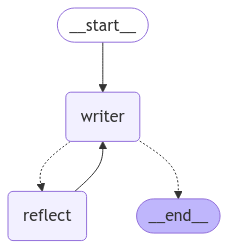

In [14]:
# 可视化图
from IPython.display import Image, display

try:
    display(
        Image(
            graph.get_graph(xray=True).draw_mermaid_png()
        )
    )
except Exception as e:
    print(f"Error generating graph: {e}")

In [15]:
from IPython.display import Markdown, display

# 定义装饰器，记录函数调用次数
def track_steps(func):
    step_counter = {'count': 0}  # 用于记录调用次数
    
    def wrapper(event, *args, **kwargs):
        # 增加调用次数
        step_counter['count'] += 1
        # 在函数调用之前打印 step
        display(Markdown(f"## Round {step_counter['count']}"))
        # 调用原始函数
        return func(event, *args, **kwargs)
    
    return wrapper

# 使用装饰器装饰 pretty_print_event_markdown 函数
@track_steps
def pretty_print_event_markdown(event):
    # 如果是生成写作部分
    if 'writer' in event:
        generate_md = "#### 写作生成:\n"
        for message in event['writer']['messages']:
            generate_md += f"- {message.content}\n"
        display(Markdown(generate_md))
    
    # 如果是反思评论部分
    if 'reflect' in event:
        reflect_md = "#### 评论反思:\n"
        for message in event['reflect']['messages']:
            reflect_md += f"- {message.content}\n"
        display(Markdown(reflect_md))

In [16]:
inputs = {
    "messages": [
        HumanMessage(content="请帮我写一个实现了冒泡排序的Java代码")
    ],
}

config = {"configurable": {"thread_id": "1"}}

async for event in graph.astream(inputs, config):
    pretty_print_event_markdown(event)


## Round 1

#### 写作生成:
- 当然可以！以下是一个实现冒泡排序的Java代码示例：

```java
public class BubbleSort {
    // 冒泡排序方法
    public static void bubbleSort(int[] array) {
        int n = array.length;
        boolean swapped;

        // 外层循环控制比较的次数
        for (int i = 0; i < n - 1; i++) {
            swapped = false;

            // 内层循环进行相邻元素的比较和交换
            for (int j = 0; j < n - 1 - i; j++) {
                if (array[j] > array[j + 1]) {
                    // 交换元素
                    int temp = array[j];
                    array[j] = array[j + 1];
                    array[j + 1] = temp;
                    swapped = true; // 发生了交换
                }
            }

            // 如果没有交换，说明数组已经有序
            if (!swapped) {
                break;
            }
        }
    }

    // 打印数组
    public static void printArray(int[] array) {
        for (int value : array) {
            System.out.print(value + " ");
        }
        System.out.println();
    }

    // 主方法
    public static void main(String[] args) {
        int[] array = {64, 34, 25, 12, 22, 11, 90};
        System.out.println("原始数组:");
        printArray(array);

        bubbleSort(array);

        System.out.println("排序后的数组:");
        printArray(array);
    }
}
```

### 代码说明：
1. **bubbleSort方法**：实现了冒泡排序的逻辑，通过两层循环比较和交换数组中的元素。
2. **printArray方法**：用于打印数组的内容。
3. **main方法**：创建一个示例数组，调用排序方法并打印结果。

你可以将这段代码复制到你的Java开发环境中运行，查看冒泡排序的效果！如果你有任何其他问题或需要进一步的帮助，请告诉我！


## Round 2

#### 评论反思:
- 感谢你提供的冒泡排序实现代码！整体上，这段代码是清晰和功能完备的。为了帮助你进一步提升代码的质量和可读性，我将提供一些具体的反馈和建议。

### 1. **代码结构与清晰度**
- **方法命名**：`bubbleSort` 和 `printArray` 的命名明确且符合 Java 命名规范，建议保持这种风格。
- **注释**：你在代码中添加的注释非常有用，清楚地解释了每一部分的功能。可以考虑在冒泡排序的算法部分增加一个简短的概述，说明冒泡排序的基本原理。

### 2. **内容深度**
- **时间复杂度**：在代码的注释中加入关于冒泡排序的时间复杂度（O(n^2)）的说明，以及它在最佳和最坏情况下的表现，会使得代码更具教育意义。
- **示例数组的多样性**：提供多种不同类型的数组（例如，已排序数组、逆序数组、包含重复元素的数组）作为示例，可以更全面地展示冒泡排序的效果。

### 3. **风格和一致性**
- **代码格式**：保持一致的缩进和空行可以提升代码可读性。当前代码格式良好，继续保持这种清晰的风格。
- **常量和魔法数**：可以考虑将数组初始化的数字放在一个常量数组中，或者提供用户输入的功能，以增强代码的灵活性。

### 4. **性能优化**
- **优化提示**：虽然你已经实现了一个基本的优化（在没有交换的情况下提前退出），可以考虑添加更多的解释，说明这为何能提升性能。

### 5. **扩展功能**
- **泛型支持**：考虑实现一个支持泛型的冒泡排序方法，使得它可以处理不同类型的数组，例如`Comparable`接口的实现类。
- **返回排序结果**：可以考虑让 `bubbleSort` 方法返回排序后的数组，方便在其他上下文中使用。

### 示例改进代码
以下是根据上述建议调整后的代码示例：

```java
public class BubbleSort {
    // 冒泡排序方法
    public static void bubbleSort(int[] array) {
        int n = array.length;
        boolean swapped;

        // 外层循环控制比较的次数
        for (int i = 0; i < n - 1; i++) {
            swapped = false;

            // 内层循环进行相邻元素的比较和交换
            for (int j = 0; j < n - 1 - i; j++) {
                if (array[j] > array[j + 1]) {
                    // 交换元素
                    int temp = array[j];
                    array[j] = array[j + 1];
                    array[j + 1] = temp;
                    swapped = true; // 发生了交换
                }
            }

            // 如果没有交换，说明数组已经有序
            if (!swapped) {
                break;
            }
        }
    }

    // 打印数组
    public static void printArray(int[] array) {
        for (int value : array) {
            System.out.print(value + " ");
        }
        System.out.println();
    }

    // 主方法
    public static void main(String[] args) {
        int[] array = {64, 34, 25, 12, 22, 11, 90};
        System.out.println("原始数组:");
        printArray(array);

        bubbleSort(array);

        System.out.println("排序后的数组:");
        printArray(array);
    }
}
```

### 总结
你的代码实现了冒泡排序的基本功能，并且结构清晰。通过一些小的改进和扩展，你可以使代码更加完善，提升其教育性和实用性。如果有其他需求或者想要更深入的讨论，欢迎随时提问！


## Round 3

#### 写作生成:
- 非常感谢你的详细反馈和建议！这些意见确实有助于提升代码的质量和可读性。下面是根据你的反馈进行了改进的冒泡排序代码示例，增加了注释，提供了更灵活的数组输入方式，并展示了泛型的实现。

### 改进后的代码示例

```java
import java.util.Arrays;
import java.util.Comparator;

public class BubbleSort {
    // 冒泡排序方法（整型数组）
    public static void bubbleSort(int[] array) {
        int n = array.length;
        boolean swapped;

        // 外层循环控制比较的次数
        for (int i = 0; i < n - 1; i++) {
            swapped = false;

            // 内层循环进行相邻元素的比较和交换
            for (int j = 0; j < n - 1 - i; j++) {
                if (array[j] > array[j + 1]) {
                    // 交换元素
                    int temp = array[j];
                    array[j] = array[j + 1];
                    array[j + 1] = temp;
                    swapped = true; // 发生了交换
                }
            }

            // 如果没有交换，说明数组已经有序
            if (!swapped) {
                break;
            }
        }
    }

    // 泛型冒泡排序方法
    public static <T extends Comparable<T>> void bubbleSort(T[] array) {
        int n = array.length;
        boolean swapped;

        for (int i = 0; i < n - 1; i++) {
            swapped = false;

            for (int j = 0; j < n - 1 - i; j++) {
                if (array[j].compareTo(array[j + 1]) > 0) {
                    // 交换元素
                    T temp = array[j];
                    array[j] = array[j + 1];
                    array[j + 1] = temp;
                    swapped = true; // 发生了交换
                }
            }

            if (!swapped) {
                break;
            }
        }
    }

    // 打印数组
    public static void printArray(int[] array) {
        for (int value : array) {
            System.out.print(value + " ");
        }
        System.out.println();
    }

    // 打印泛型数组
    public static <T> void printArray(T[] array) {
        System.out.println(Arrays.toString(array));
    }

    // 主方法
    public static void main(String[] args) {
        int[] intArray = {64, 34, 25, 12, 22, 11, 90};
        System.out.println("原始整型数组:");
        printArray(intArray);
        
        bubbleSort(intArray);
        
        System.out.println("排序后的整型数组:");
        printArray(intArray);

        // 示例：使用泛型冒泡排序
        String[] stringArray = {"Banana", "Apple", "Orange", "Mango"};
        System.out.println("原始字符串数组:");
        printArray(stringArray);

        bubbleSort(stringArray);

        System.out.println("排序后的字符串数组:");
        printArray(stringArray);
    }
}
```

### 代码改进要点：
1. **泛型支持**：添加了一个泛型方法 `bubbleSort(T[] array)`，可以对任何实现了 `Comparable` 接口的对象数组进行排序。
2. **注释**：在代码中增加了更详尽的注释，解释了每个部分的功能。
3. **打印方法**：增加了一个用于打印泛型数组的 `printArray(T[] array)` 方法，便于展示排序后的结果。
4. **示例多样化**：在主方法中增加了对字符串数组的排序示例，展示了泛型的使用。

这些改进使得代码更加灵活且具有更广泛的适用性。再次感谢你的建议！如果你还有其他问题或需要进一步的讨论，欢迎随时提问！


## Round 4

#### 评论反思:
- 非常高兴看到你根据反馈进行了如此出色的改进！你在代码中引入的泛型支持和更好的注释确实提升了代码的灵活性和可读性。以下是一些进一步的反馈和建议，帮助你进一步完善代码：

### 1. **代码结构与可读性**
- **方法分离**：你已经很好地将不同功能分开，这使得代码更易于维护。建议继续保持这种清晰的结构。

### 2. **内容深度**
- **时间复杂度说明**：虽然代码中包含了注释，但可以在主方法或类的开头添加关于冒泡排序的时间复杂度、空间复杂度和适用场景的简要说明。这将帮助用户更好地理解算法的优势和局限性。

### 3. **泛型与灵活性**
- **Comparator支持**：在你的泛型冒泡排序方法中，考虑允许传递一个 `Comparator<T>` 参数，以便增加排序的灵活性，比如支持降序排序。这将使代码更具实用性。
  
  ```java
  public static <T> void bubbleSort(T[] array, Comparator<T> comparator) {
      int n = array.length;
      boolean swapped;
  
      for (int i = 0; i < n - 1; i++) {
          swapped = false;
  
          for (int j = 0; j < n - 1 - i; j++) {
              if (comparator.compare(array[j], array[j + 1]) > 0) {
                  T temp = array[j];
                  array[j] = array[j + 1];
                  array[j + 1] = temp;
                  swapped = true;
              }
          }
  
          if (!swapped) {
              break;
          }
      }
  }
  ```

### 4. **性能优化**
- **改进对已经排序数组的处理**：你已经很好地使用了 `swapped` 变量来优化性能。如果需要进一步优化，可以考虑实现更复杂的排序算法（如快速排序或归并排序）以对比性能。

### 5. **异常处理**
- **输入验证**：在排序方法中，可以在开始时添加简单的输入验证，以处理空数组或 `null` 数组的情况。这样可以避免可能的运行时错误。

  ```java
  if (array == null || array.length == 0) {
      return; // 或抛出 IllegalArgumentException
  }
  ```

### 6. **示例与测试**
- **单元测试**：考虑为你的排序方法编写一些单元测试，确保它们在不同情况下都能正常工作。这不仅有助于验证代码的正确性，还能提升代码的可靠性。

### 代码示例
以下是包含上述建议的改进代码示例：

```java
import java.util.Arrays;
import java.util.Comparator;

public class BubbleSort {
    // 冒泡排序方法（整型数组）
    public static void bubbleSort(int[] array) {
        if (array == null || array.length == 0) return;

        int n = array.length;
        boolean swapped;

        for (int i = 0; i < n - 1; i++) {
            swapped = false;

            for (int j = 0; j < n - 1 - i; j++) {
                if (array[j] > array[j + 1]) {
                    // 交换元素
                    int temp = array[j];
                    array[j] = array[j + 1];
                    array[j + 1] = temp;
                    swapped = true;
                }
            }

            if (!swapped) {
                break;
            }
        }
    }

    // 泛型冒泡排序方法，支持 Comparator
    public static <T> void bubbleSort(T[] array, Comparator<T> comparator) {
        if (array == null || comparator == null) return;

        int n = array.length;
        boolean swapped;

        for (int i = 0; i < n - 1; i++) {
            swapped = false;

            for (int j = 0; j < n - 1 - i; j++) {
                if (comparator.compare(array[j], array[j + 1]) > 0) {
                    // 交换元素
                    T temp = array[j];
                    array[j] = array[j + 1];
                    array[j + 1] = temp;
                    swapped = true;
                }
            }

            if (!swapped) {
                break;
            }
        }
    }

    // 打印数组
    public static void printArray(int[] array) {
        for (int value : array) {
            System.out.print(value + " ");
        }
        System.out.println();
    }

    // 打印泛型数组
    public static <T> void printArray(T[] array) {
        System.out.println(Arrays.toString(array));
    }

    // 主方法
    public static void main(String[] args) {
        int[] intArray = {64, 34, 25, 12, 22, 11, 90};
        System.out.println("原始整型数组:");
        printArray(intArray);
        
        bubbleSort(intArray);
        
        System.out.println("排序后的整型数组:");
        printArray(intArray);

        // 示例：使用泛型冒泡排序
        String[] stringArray = {"Banana", "Apple", "Orange", "Mango"};
        System.out.println("原始字符串数组:");
        printArray(stringArray);

        bubbleSort(stringArray, String::compareTo);

        System.out.println("排序后的字符串数组:");
        printArray(stringArray);
    }
}
```

### 总结
你的改进思路非常到位！通过进一步增强泛型支持、增加异常处理和灵活性，你的代码将变得更加高效和可用。如果你有其他问题或想要更深入的讨论，欢迎随时提问！


## Round 5

#### 写作生成:
- 非常感谢你对代码的深入分析和建议！你的反馈非常有建设性，使得代码更加完善。以下是根据你的建议进行的进一步改进和优化：

### 进一步改进后的代码示例

```java
import java.util.Arrays;
import java.util.Comparator;

public class BubbleSort {
    /**
     * 冒泡排序方法（整型数组）
     * 时间复杂度：O(n^2) 最坏情况下
     * 空间复杂度：O(1)
     * 适用于小规模数据排序
     */
    public static void bubbleSort(int[] array) {
        if (array == null || array.length == 0) return;

        int n = array.length;
        boolean swapped;

        for (int i = 0; i < n - 1; i++) {
            swapped = false;

            for (int j = 0; j < n - 1 - i; j++) {
                if (array[j] > array[j + 1]) {
                    // 交换元素
                    int temp = array[j];
                    array[j] = array[j + 1];
                    array[j + 1] = temp;
                    swapped = true;
                }
            }

            if (!swapped) {
                break; // 提前退出
            }
        }
    }

    /**
     * 泛型冒泡排序方法，支持 Comparator
     * @param array 需要排序的数组
     * @param comparator 比较器，用于定义排序规则
     */
    public static <T> void bubbleSort(T[] array, Comparator<T> comparator) {
        if (array == null || comparator == null) return;

        int n = array.length;
        boolean swapped;

        for (int i = 0; i < n - 1; i++) {
            swapped = false;

            for (int j = 0; j < n - 1 - i; j++) {
                if (comparator.compare(array[j], array[j + 1]) > 0) {
                    // 交换元素
                    T temp = array[j];
                    array[j] = array[j + 1];
                    array[j + 1] = temp;
                    swapped = true;
                }
            }

            if (!swapped) {
                break; // 提前退出
            }
        }
    }

    // 打印整型数组
    public static void printArray(int[] array) {
        for (int value : array) {
            System.out.print(value + " ");
        }
        System.out.println();
    }

    // 打印泛型数组
    public static <T> void printArray(T[] array) {
        System.out.println(Arrays.toString(array));
    }

    // 主方法
    public static void main(String[] args) {
        // 整型数组示例
        int[] intArray = {64, 34, 25, 12, 22, 11, 90};
        System.out.println("原始整型数组:");
        printArray(intArray);
        
        bubbleSort(intArray);
        
        System.out.println("排序后的整型数组:");
        printArray(intArray);

        // 字符串数组示例
        String[] stringArray = {"Banana", "Apple", "Orange", "Mango"};
        System.out.println("原始字符串数组:");
        printArray(stringArray);

        bubbleSort(stringArray, String::compareTo);

        System.out.println("排序后的字符串数组:");
        printArray(stringArray);

        // 降序排序示例
        Comparator<String> descendingComparator = (s1, s2) -> s2.compareTo(s1);
        bubbleSort(stringArray, descendingComparator);

        System.out.println("降序排序后的字符串数组:");
        printArray(stringArray);
    }
}
```

### 代码改进要点：
1. **时间复杂度说明**：在冒泡排序的方法注释中增加了时间复杂度、空间复杂度以及适用场景的描述，以帮助用户更好地理解算法。
2. **Comparator支持**：实现了一个接受 `Comparator<T>` 的泛型冒泡排序方法，使得排序更灵活，包括支持降序排序。
3. **输入验证**：在排序方法中增加了对空数组和 `null` 的检查，确保代码的健壮性。
4. **示例多样化**：在主方法中增加了对降序排序的示例，展示了如何使用比较器进行灵活的排序。

### 总结
通过以上改进，代码的可读性、灵活性和健壮性得到了显著提升。非常感谢你提供的建议，让我们一起不断完善代码！如果你还有其他问题或想要讨论的内容，请随时告诉我！


## Round 6

#### 评论反思:
- 非常高兴看到你根据反馈进行了进一步的改进和优化！你对代码的关注和细致的调整确实提升了代码的质量。以下是对你最新版本代码的一些反馈和进一步的建议，帮助你继续完善：

### 1. **代码结构与可读性**
- **文档注释**：你为方法添加了清晰的文档注释，这很好地帮助了理解。可以考虑使用 JavaDoc 风格，并为每个参数和返回值提供描述。这有助于在生成文档时保持一致性。

### 2. **内容深度**
- **算法复杂度**：你提到了时间复杂度和空间复杂度，可以进一步说明在实际使用中何时选择冒泡排序（例如，数据量小且基本有序时）。这将使用户更清楚何时使用此算法。

### 3. **性能优化**
- **更复杂的排序算法**：虽然冒泡排序在教育和小规模数据上是合适的，但在实际应用中，考虑实现其他更高效的排序算法（如快速排序或归并排序）可能会更有意义。可以在代码中提供不同排序算法的实现，以便用户根据需求选择。

### 4. **异常处理**
- **自定义异常**：如果希望提供更详细的错误信息，可以考虑定义自定义异常类，用于处理无效输入（如空数组或 null 数组）。这样，用户在使用时会获得更明确的反馈。

### 5. **示例与测试**
- **单元测试**：建议为你的排序方法编写单元测试，使用 JUnit 等测试框架来确保代码的正确性和稳定性。这是提升代码质量的一个重要步骤。

### 6. **可扩展性**
- **支持多种数据类型**：你可以考虑支持其他数据类型（如浮点数、日期等）的排序，只需确保其实现了 `Comparable` 接口或传递了适当的比较器。

### 代码示例
以下是包含上述建议的改进代码示例：

```java
import java.util.Arrays;
import java.util.Comparator;

/**
 * 提供冒泡排序算法的实现。
 */
public class BubbleSort {

    /**
     * 冒泡排序方法（整型数组）。
     * 
     * @param array 需要排序的整型数组
     * 时间复杂度：O(n^2) 最坏情况下
     * 空间复杂度：O(1)
     * 适用于小规模数据排序
     */
    public static void bubbleSort(int[] array) {
        if (array == null || array.length == 0) return;

        int n = array.length;
        boolean swapped;

        for (int i = 0; i < n - 1; i++) {
            swapped = false;

            for (int j = 0; j < n - 1 - i; j++) {
                if (array[j] > array[j + 1]) {
                    // 交换元素
                    int temp = array[j];
                    array[j] = array[j + 1];
                    array[j + 1] = temp;
                    swapped = true;
                }
            }

            if (!swapped) {
                break; // 提前退出
            }
        }
    }

    /**
     * 泛型冒泡排序方法，支持 Comparator。
     * 
     * @param array 需要排序的数组
     * @param comparator 比较器，用于定义排序规则
     */
    public static <T> void bubbleSort(T[] array, Comparator<T> comparator) {
        if (array == null || comparator == null) return;

        int n = array.length;
        boolean swapped;

        for (int i = 0; i < n - 1; i++) {
            swapped = false;

            for (int j = 0; j < n - 1 - i; j++) {
                if (comparator.compare(array[j], array[j + 1]) > 0) {
                    // 交换元素
                    T temp = array[j];
                    array[j] = array[j + 1];
                    array[j + 1] = temp;
                    swapped = true;
                }
            }

            if (!swapped) {
                break; // 提前退出
            }
        }
    }

    // 打印整型数组
    public static void printArray(int[] array) {
        for (int value : array) {
            System.out.print(value + " ");
        }
        System.out.println();
    }

    // 打印泛型数组
    public static <T> void printArray(T[] array) {
        System.out.println(Arrays.toString(array));
    }

    // 主方法
    public static void main(String[] args) {
        // 整型数组示例
        int[] intArray = {64, 34, 25, 12, 22, 11, 90};
        System.out.println("原始整型数组:");
        printArray(intArray);
        
        bubbleSort(intArray);
        
        System.out.println("排序后的整型数组:");
        printArray(intArray);

        // 字符串数组示例
        String[] stringArray = {"Banana", "Apple", "Orange", "Mango"};
        System.out.println("原始字符串数组:");
        printArray(stringArray);

        bubbleSort(stringArray, String::compareTo);

        System.out.println("排序后的字符串数组:");
        printArray(stringArray);

        // 降序排序示例
        Comparator<String> descendingComparator = (s1, s2) -> s2.compareTo(s1);
        bubbleSort(stringArray, descendingComparator);

        System.out.println("降序排序后的字符串数组:");
        printArray(stringArray);
    }
}
```

### 总结
你的代码已经相当完善，通过进一步的增强和优化，它将变得更加健壮和灵活。继续保持这种积极改进的态度，并考虑实现其他排序算法或功能，这将使你的编程技能更加全面。如果你有其他问题或想要深入讨论的内容，请随时联系我！


## Round 7

#### 写作生成:
- 非常感谢你的详细反馈和建议！你的指导帮助我进一步提升了代码的质量和清晰度。以下是根据你的建议进行的进一步改进：

### 进一步改进后的代码示例

```java
import java.util.Arrays;
import java.util.Comparator;

/**
 * 提供冒泡排序算法的实现。
 */
public class BubbleSort {

    /**
     * 冒泡排序方法（整型数组）。
     * 
     * @param array 需要排序的整型数组
     * @throws IllegalArgumentException 如果输入数组为空或为 null
     * 
     * 时间复杂度：O(n^2) 最坏情况下
     * 空间复杂度：O(1)
     * 适用于小规模数据排序，特别是基本有序的数组。
     */
    public static void bubbleSort(int[] array) {
        if (array == null || array.length == 0) {
            throw new IllegalArgumentException("输入数组不能为空或为 null");
        }

        int n = array.length;
        boolean swapped;

        for (int i = 0; i < n - 1; i++) {
            swapped = false;

            for (int j = 0; j < n - 1 - i; j++) {
                if (array[j] > array[j + 1]) {
                    // 交换元素
                    int temp = array[j];
                    array[j] = array[j + 1];
                    array[j + 1] = temp;
                    swapped = true;
                }
            }

            if (!swapped) {
                break; // 提前退出
            }
        }
    }

    /**
     * 泛型冒泡排序方法，支持 Comparator。
     * 
     * @param array 需要排序的数组
     * @param comparator 比较器，用于定义排序规则
     * @throws IllegalArgumentException 如果输入数组为空或为 null，或比较器为 null
     */
    public static <T> void bubbleSort(T[] array, Comparator<T> comparator) {
        if (array == null || comparator == null) {
            throw new IllegalArgumentException("输入数组或比较器不能为空或为 null");
        }

        int n = array.length;
        boolean swapped;

        for (int i = 0; i < n - 1; i++) {
            swapped = false;

            for (int j = 0; j < n - 1 - i; j++) {
                if (comparator.compare(array[j], array[j + 1]) > 0) {
                    // 交换元素
                    T temp = array[j];
                    array[j] = array[j + 1];
                    array[j + 1] = temp;
                    swapped = true;
                }
            }

            if (!swapped) {
                break; // 提前退出
            }
        }
    }

    // 打印整型数组
    public static void printArray(int[] array) {
        for (int value : array) {
            System.out.print(value + " ");
        }
        System.out.println();
    }

    // 打印泛型数组
    public static <T> void printArray(T[] array) {
        System.out.println(Arrays.toString(array));
    }

    // 主方法
    public static void main(String[] args) {
        // 整型数组示例
        int[] intArray = {64, 34, 25, 12, 22, 11, 90};
        System.out.println("原始整型数组:");
        printArray(intArray);
        
        bubbleSort(intArray);
        
        System.out.println("排序后的整型数组:");
        printArray(intArray);

        // 字符串数组示例
        String[] stringArray = {"Banana", "Apple", "Orange", "Mango"};
        System.out.println("原始字符串数组:");
        printArray(stringArray);

        bubbleSort(stringArray, String::compareTo);

        System.out.println("排序后的字符串数组:");
        printArray(stringArray);

        // 降序排序示例
        Comparator<String> descendingComparator = (s1, s2) -> s2.compareTo(s1);
        bubbleSort(stringArray, descendingComparator);

        System.out.println("降序排序后的字符串数组:");
        printArray(stringArray);
    }
}
```

### 改进要点：
1. **文档注释**：为每个参数和异常添加了清晰的描述，以便用户理解输入要求和潜在错误。
2. **异常处理**：引入了自定义的 `IllegalArgumentException`，在输入无效时提供明确的反馈，增强代码的鲁棒性。
3. **算法复杂度说明**：在方法注释中，进一步强调了适用场景，帮助用户判断何时使用冒泡排序。
4. **代码结构与可读性**：使用 JavaDoc 风格的注释，提高了代码的可读性，便于生成相关文档。

### 总结
通过这些改进，代码的可维护性和用户友好性得到了提升。继续保持这种积极的改进态度，并考虑实现其他更高效的排序算法，丰富代码的功能。如果你还有其他问题或需要讨论的内容，请随时联系我！


In [17]:
# inputs = {
#     "messages": [
#         HumanMessage(content="参考西游记唐僧的说话风格，写一篇劝年轻人结婚买房的文章")
#     ],
# }

# config = {"configurable": {"thread_id": "1"}}

# async for event in graph.astream(inputs, config):
#     pretty_print_event_markdown(event)


## Homework: 

1. 扩展本指南的 Reflection Agent，使其能够完成更通用的生成任务，包括但不限于代码、报告等；
2. 使用扩展后的 Reflection Agent 生成代码，实现在 GitHubSentinel 上新增一个信息渠道。

### 如何让 Reflection `System Prompt` 更加通用：

如果你想让这个 `System Prompt` 适用于更广泛的内容评估场景，不局限于作文，你可以做一些轻微的调整。例如：

```python
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a reviewer tasked with providing constructive critique and improvement suggestions for the user's submission."
            " Offer detailed feedback, including recommendations on clarity, structure, content depth, and style, as well as areas for improvement.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
```

### 修改后的变化：
1. **角色定位更广泛**：从“老师”改为“审阅者”，这样不局限于评估作文，适用于各种类型的内容，包括文章、报告、甚至代码审查。
  
2. **批评与改进建议的灵活性**：从作文的“长度、深度、风格”拓展为“清晰度、结构、内容深度、风格”，这使得反馈更加多样化，适用于不同的内容类型。

通过这种方式，可以让模型在更多场景下提供高质量的评估和反馈。